In [27]:
import numpy as np

import pandas as pd
from collections import Counter
from wordcloud import WordCloud
from pandarallel import pandarallel
import seaborn as sns
from matplotlib import pyplot as plt

from reviews.config import processed_data_dir, asum_input_dir
from reviews.preprocess import preprocess

pandarallel.initialize(progress_bar=True, nb_workers=8)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [19]:
# read data
reviews_df = pd.read_json(
    processed_data_dir / "products_reviews.json.gz", orient="records"
)
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152363 entries, 0 to 152362
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   asin         152363 non-null  object        
 1   overall      152363 non-null  int64         
 2   summary      152363 non-null  object        
 3   text         152363 non-null  object        
 4   timestamp    152363 non-null  datetime64[ns]
 5   vote         152363 non-null  int64         
 6   brand        152363 non-null  object        
 7   category     152363 non-null  object        
 8   description  152363 non-null  object        
 9   price        152363 non-null  float64       
 10  title        152363 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(7)
memory usage: 13.9+ MB


In [20]:
# apply preprocessing
reviews_df["summary"] = reviews_df["summary"].astype("string")
reviews_df["text"] = reviews_df["text"].astype("string")

summary_text = []
for i, row in reviews_df.iterrows():
    end_line = ".\n"
    if row['summary'].endswith('.'):
        end_line = "\n"
    summary_text.append(row['summary'] + end_line + row['text'])
reviews_df["summary+text"] = summary_text

reviews_df["tokens"] = reviews_df["summary+text"].parallel_apply(
    lambda x: preprocess(x, lemmatization=True)
)
reviews_df.to_json(processed_data_dir / "preprocessed_reviews_stemming.json.gz") # attenti al nome!!!

/home/ubuntu/Desktop/amazon-reviews/venv/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/home/ubuntu/Desktop/amazon-reviews/venv/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/home/ubuntu/Desktop/amazon-reviews/venv/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/home/ubuntu/Desktop/amazon-reviews/venv/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file an

In [21]:
tokens = [word for doc in reviews_df["tokens"] for sent in doc for word in sent]
c = Counter(tokens)

print("Tokens:", len(set(tokens)))

Tokens: 50725


/home/ubuntu/Desktop/amazon-reviews/venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


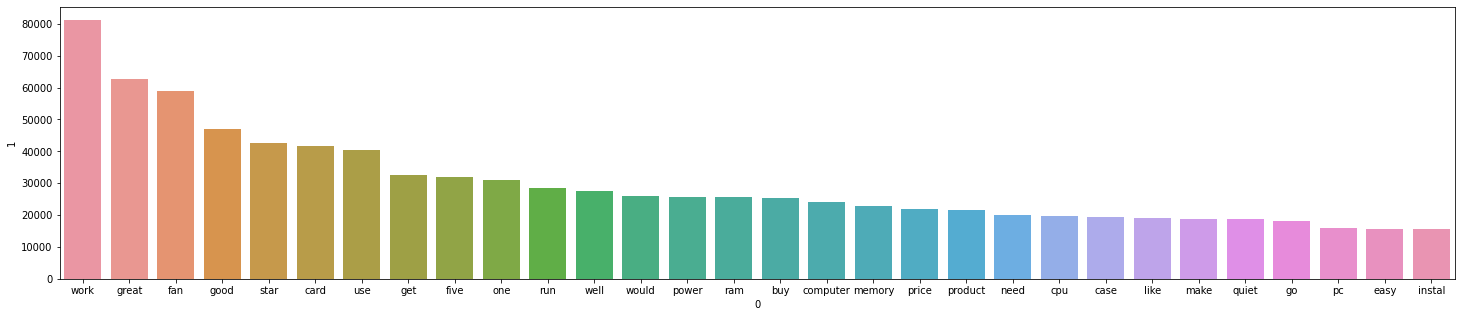

In [29]:
data = pd.DataFrame(Counter(tokens).most_common(30))
_, ax = plt.subplots(figsize=(25, 5))
sns.barplot(data[0], data[1], ax=ax)

pass

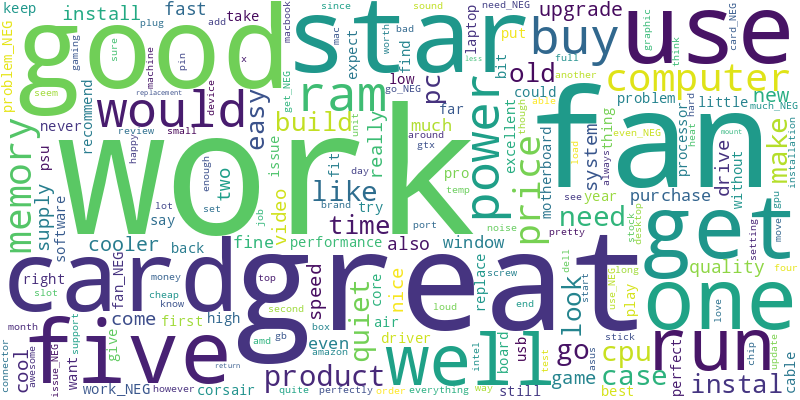

In [22]:
# generate the word cloud
wc = WordCloud(
    collocations=False,
    prefer_horizontal=0.6,
    width=800,
    height=400,
    background_color="white",
)
wc.fit_words(c)
wc.to_image()

In [ ]:
# ground truth polarity
reviews_df["overall"] = reviews_df["overall"].apply(
    lambda x: "positive" if x > 3 else ("neutral" if x == 3 else "negative")
)

In [42]:
positive_df = reviews_df[reviews_df["overall"] == "positive"]
positive_tokens = [word for doc in positive_df["tokens"] for sent in doc for word in sent]
pos_c = Counter(positive_tokens)

print("positive tokens:", len(set(positive_tokens)))

negative_df = reviews_df[reviews_df["overall"] == "negative"]
negative_tokens = [word for doc in negative_df["tokens"] for sent in doc for word in sent]
neg_c = Counter(negative_tokens)

print("negative tokens:", len(set(negative_tokens)))

positive tokens: 44710
negative tokens: 19921


/home/ubuntu/Desktop/amazon-reviews/venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ubuntu/Desktop/amazon-reviews/venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


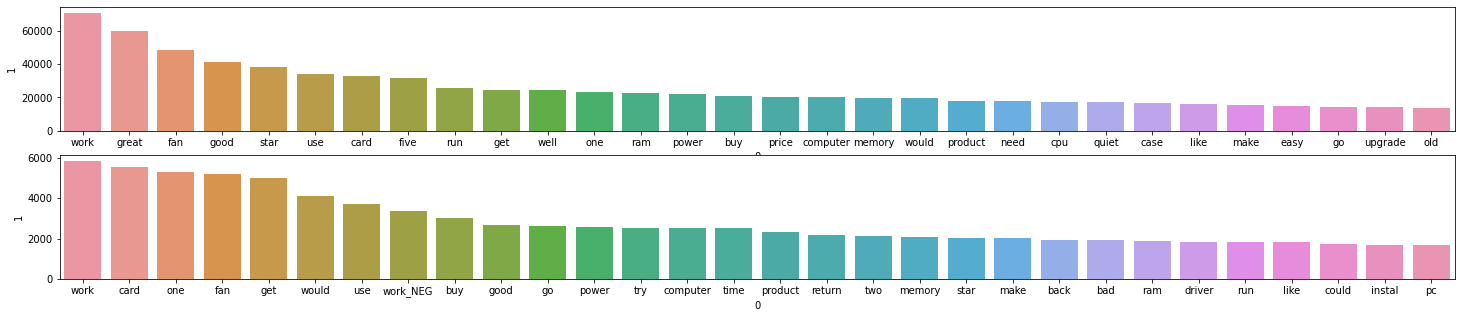

In [43]:
pos_data = pd.DataFrame(Counter(positive_tokens).most_common(30))
neg_data = pd.DataFrame(Counter(negative_tokens).most_common(30))

_, ax = plt.subplots(2, 1, figsize=(25, 5))
sns.barplot(pos_data[0], pos_data[1], ax=ax[0])
sns.barplot(neg_data[0], neg_data[1], ax=ax[1])
pass

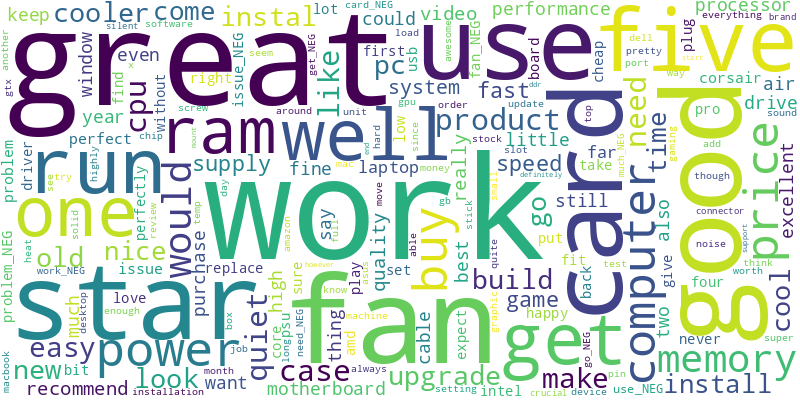

In [46]:
# generate the word cloud
wc = WordCloud(
    collocations=False,
    prefer_horizontal=0.6,
    width=800,
    height=400,
    background_color="white",
)
wc.fit_words(pos_c)
wc.to_image()

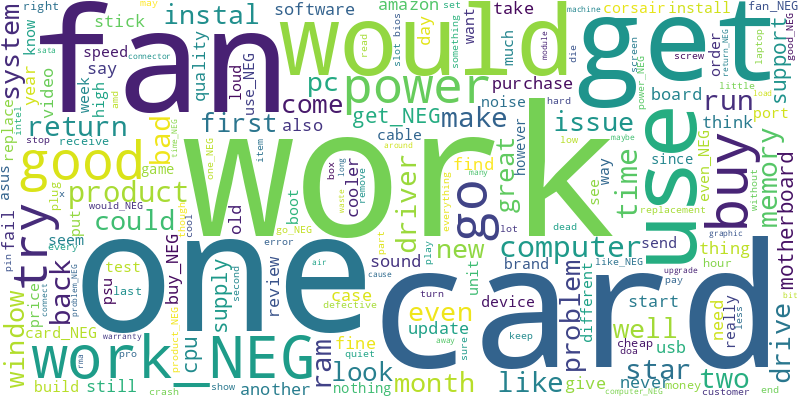

In [45]:
# generate the word cloud
wc = WordCloud(
    collocations=False,
    prefer_horizontal=0.6,
    width=800,
    height=400,
    background_color="white",
)
wc.fit_words(neg_c)
wc.to_image()

In [47]:
vocabulary = dict((e, i) for i, e in enumerate(set(tokens)))
print("Vocabulary size:", len(vocabulary))

# save vocabulary for asum input
np.save(asum_input_dir / "vocabulary", vocabulary)

Vocabulary size: 44710


# Look for bad results

In [24]:
# check long words
set([t for t in tokens if len(t) > 15])

{'abreviations_NEG',
 'acceleration_NEG',
 'accessvbscript_NEG',
 'accidentally_NEG',
 'accommodating_NEG',
 'accommodation_NEG',
 'accomodating_NEG',
 'accomplishment_NEG',
 'accumulation_NEG',
 'accumulative_NEG',
 'acknowledgement_NEG',
 'acknowledgment_NEG',
 'additionally_NEG',
 'administration_NEG',
 'administrator_NEG',
 'adubbproductions',
 'advantageous_NEG',
 'advertisement_NEG',
 'advertisiing_NEG',
 'aesthetically_NEG',
 'affordability_NEG',
 'aforementioned_NEG',
 'afterthought_NEG',
 'airconditioning_NEG',
 'aircraftvlanding',
 'amazonpcbuildercom',
 'amazonpcbuildercom_NEG',
 'amdcleanuputility',
 'amplification_NEG',
 'amuletdevices_NEG',
 'announcement_NEG',
 'antialiasing_NEG',
 'antivibration_NEG',
 'appreciation_NEG',
 'appreciative_NEG',
 'appropriately_NEG',
 'approximately_NEG',
 'approximation_NEG',
 'archaeologically_NEG',
 'architectural_NEG',
 'architecture_NEG',
 'argumentatively_NEG',
 'arquitecture_NEG',
 'astonishingly_NEG',
 'astronomical_NEG',
 'astroph

In [25]:
strange_tokens = ["clockwatchdogtimeout"]

In [26]:
for q in strange_tokens:
    for i, row in reviews_df.iterrows():
        if q in [t for s in row["tokens"] for t in s]:
            print(row["text"])
            print(row["tokens"])
            print("\n")

Lasted about 3 months, now continually getting CLOCK_WATCHDOG_TIMEOUT errors while doing menial tasks. I blame poor binning. This is 6600k #2 for this build, never clocked past 3.9.
[['blame', 'poor', 'binning'], ['build'], ['last', 'month', 'continually', 'get', 'clockwatchdogtimeout', 'error', 'menial', 'task'], ['blame', 'poor', 'binning'], ['build', 'never', 'clock_NEG', 'past_NEG']]


